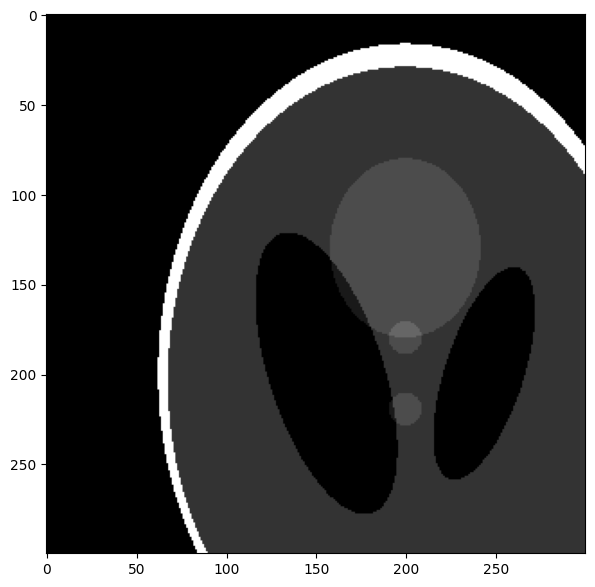

In [1]:
import torch
from torch_radon24 import Radon
# import libraries
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
plt.rcParams["figure.figsize"] = [7, 7]
import numpy as np
import time

img = shepp_logan_phantom()
img = img[:300, :300]
# define some constants
batch_size = 1
n_angles = 512

_ = plt.imshow(img, cmap="gray")

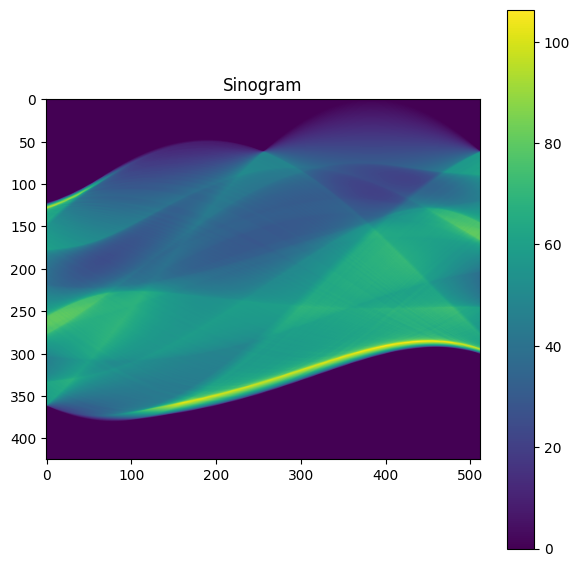

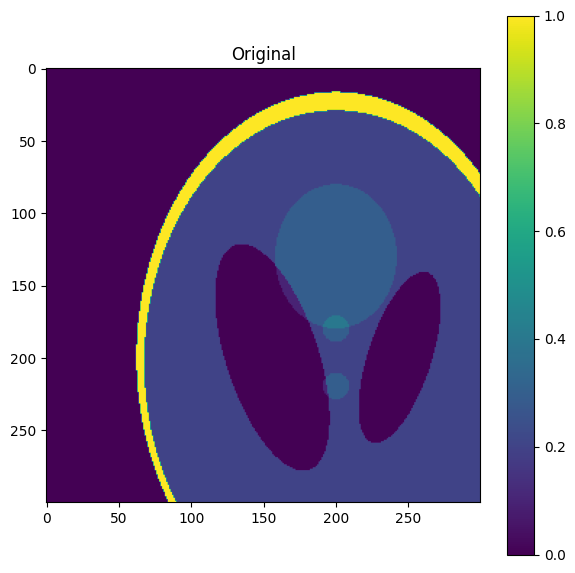

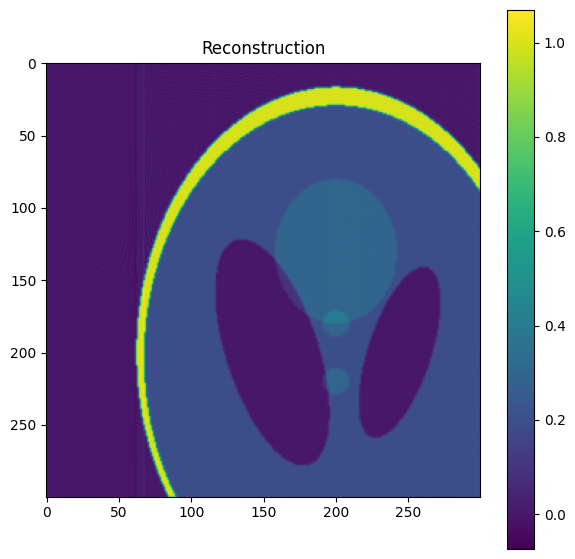

fbb error:  0.11175153915264378


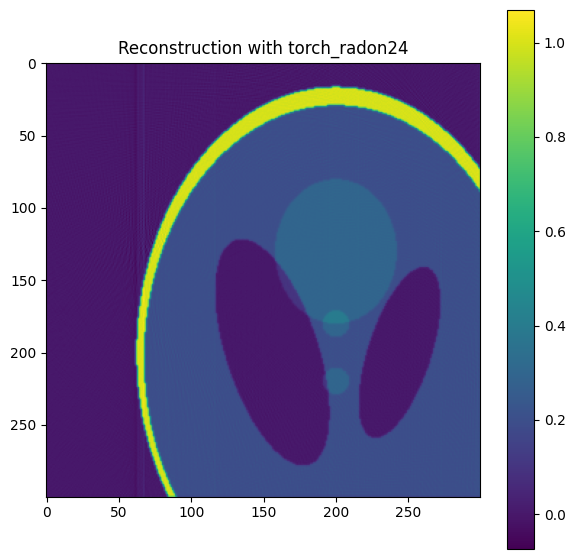

FBP Relative Error 0.11175070703029633


In [2]:
from skimage.transform import radon, iradon

# define some constants
batch_size = 1
n_angles = 512
device = torch.device("cuda")

# Generate sinogram
sinogram = radon(img, theta=np.linspace(0, 180, n_angles), circle=False)
plt.imshow(sinogram)
plt.colorbar()
plt.title("Sinogram")
plt.show()

plt.imshow(img)
plt.colorbar()
plt.title("Original")
plt.show()
# Apply filtered backprojection
reconstructed_skimage = iradon(sinogram, theta=np.linspace(0, 180, n_angles), filter_name="ramp", circle=False)
plt.imshow(reconstructed_skimage)
plt.colorbar()
plt.title("Reconstruction")
plt.show()
print("fbb error: ", np.linalg.norm(img - reconstructed_skimage) / np.linalg.norm(reconstructed_skimage))

# Apply filtered backprojection on gpu by torch_radon24
image = torch.FloatTensor(img).to(device)[None, None]
radon_op1 = Radon(thetas=np.linspace(0, np.pi, n_angles), circle=False, device=device, filter_name="ramp")
reconstructed_24 = radon_op1.filter_backprojection(torch.tensor(sinogram, dtype=torch.float32, device="cuda")[None, None])


plt.imshow(reconstructed_24[0, 0].cpu().numpy())
plt.colorbar()
plt.title("Reconstruction with torch_radon24")
plt.show()

print("FBP Relative Error", (torch.norm(image - reconstructed_24) / torch.norm(reconstructed_24)).item())

Radon time 0.9564380645751953


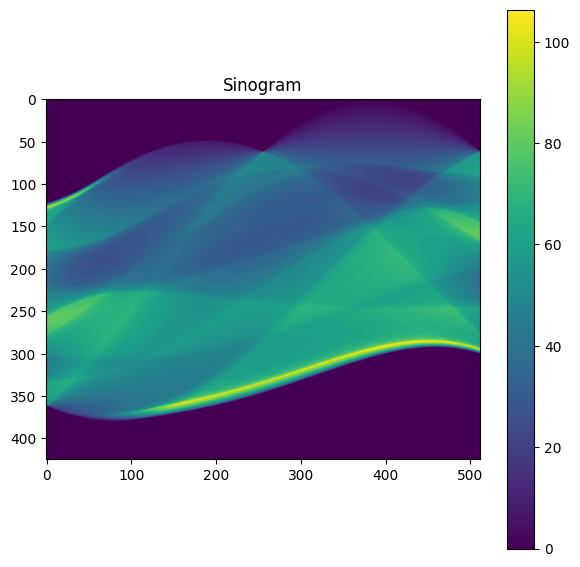

FBP time 0.5882399082183838


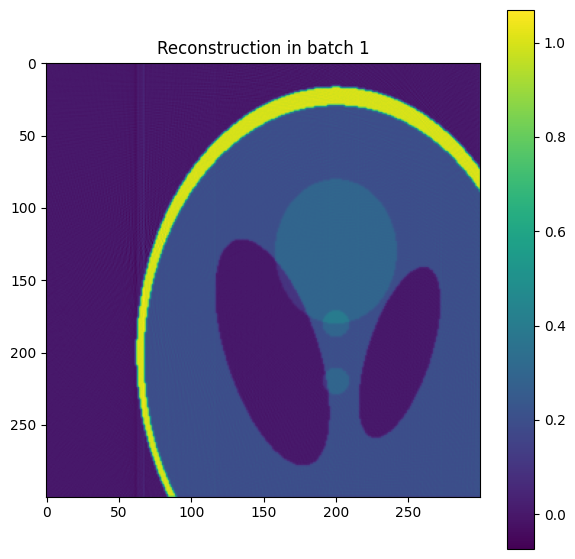

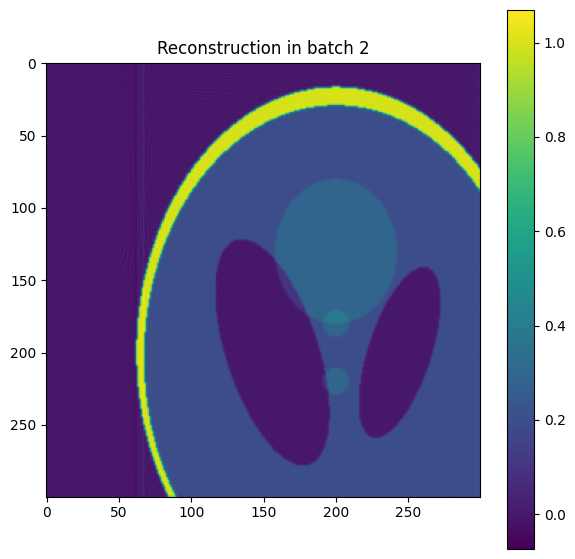

FBP Relative Error tensor(0.0559, device='cuda:0')


In [9]:
n_angles = 512
device = torch.device("cuda")

batch_size = 2
image_size = img.shape[0]
image = torch.FloatTensor(img).to(device)[None, None]
# repeat image for batch_size
image = image.repeat(batch_size, 1, 1, 1)
image_size = image.shape[-1]
# radon_op = Radon(n_angles=n_angles, image_size=image_size, circle=True, device=device)
radon_op = Radon(thetas=np.linspace(0, np.pi, 512), circle=False, filter_name="ramp", device=device)

# apply radon transformation
time_start = time.time()
sino = radon_op(image)
print("Radon time", time.time() - time_start)
plt.imshow(sino[0, 0].cpu())
plt.colorbar()
plt.title("Sinogram")
plt.show()

# apply filtered backprojection
time_start = time.time()
reconstructed = radon_op.filter_backprojection(sino)
print("FBP time", time.time() - time_start)
plt.imshow(reconstructed[0, 0].cpu())
plt.colorbar()
plt.title("Reconstruction in batch 1")
plt.show()
plt.imshow(reconstructed[1, 0].cpu())
plt.colorbar()
plt.title("Reconstruction in batch 2")
plt.show()
print("FBP Relative Error", torch.norm(image - reconstructed) / (batch_size * torch.norm(reconstructed).item()))